# Author imformation:
Fan Shengzhe, Shanghaijiaotong University, Shanghai, China  
Email: fanshengzhe@sjtu.edu.cn

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4100955198398936010
xla_global_id: -1
]


# 1.读取数据

## 1.1 基本数据的读取

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("drive/My Drive/reco/veg-fru-reco")

In [ ]:
DEBUG = False
metric_recall = True

In [ ]:
import pandas as pd
from functools import partial
import os
import tqdm
import collections
import math
import json
import numpy as np
import gc
from gensim.models import Word2Vec
import random

data_dir = './cache'
save_dir = './cache'

if not os.path.exists(save_dir):
  os.mkdir(save_dir)

log_table = pd.read_csv(os.path.join(data_dir, 'ctx_info.csv'))
# user_info = pd.read_csv(os.path.join(data_dir, 'user_info.csv'))
item_info = pd.read_csv(os.path.join(data_dir, 'item_info.csv'))
# consumer_info = pd.read_csv(os.path.join(data_dir, 'consumer_info.csv'))

emb_path = './cache'
# item_emb = pd.read_csv(os.path.join(emb_path, 'item_emb_table.csv'))

debug模式下，采样部分用户数据

In [ ]:
# debug模式下，采样10%的用户数据
if DEBUG:
  all_user_ids = log_table.user_id.unique()
  sample_user_nums = len(all_user_ids) // 10
  np.random.seed(2022)
  sampled_user_ids = np.random.choice(all_user_ids, size=sample_user_nums, replace=False)
  # log_table = log_table[log_table['user_id'].isin(sampled_user_ids)]
del log_table
gc.collect()

0

In [ ]:
# log_table

## 1.2 定义多路召回字典

In [ ]:
user_multi_recall_dict = {}

## 1.3 加速器

### 1.3.1 ANN加速器

In [ ]:
try:
  import faiss
except:
  !pip install faiss-gpu
  import faiss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.6 MB/s eta 0:00:00


### 1.3.2 pandas加速器

In [ ]:
try:
  from pandarallel import pandarallel
except:
  !pip install pandarallel
  from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16678 sha256=5313a17bfd66783e49d5d0b4a1392a2872cdef59ad3ae228498b286bcf38a279
  Stored in directory: /root/.cache/pip/wheels/62/1e/e7/f9ee096e5cc02890a6934a5670ff6e45a3400f330605bd8210
Successfully built pandarallel
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 1.3.3 多任务加速器

In [ ]:
import multitasking
import signal

In [ ]:
max_threads = multitasking.config['CPU_CORES']
multitasking.set_max_threads(max_threads)
multitasking.set_engine('process')
signal.signal(signal.SIGINT, multitasking.killall)

<function _signal.default_int_handler>

In [ ]:
multitask_cache_dir = os.path.join(save_dir, 'multitask_cache')

# 2.前置准备工作

## 2.1 拆分后的数据集读取

In [ ]:
hist_click_df = pd.read_csv(os.path.join(data_dir, 'hist_click_df.csv'))
last_click_df = pd.read_csv(os.path.join(data_dir, 'last_click_df.csv'))

# debug模式下，采样10%的用户数据
if DEBUG:
  hist_click_df = hist_click_df[hist_click_df['user_id'].isin(sampled_user_ids)]
  last_click_df = last_click_df[last_click_df['user_id'].isin(sampled_user_ids)]

## 2.2 召回评估函数

In [ ]:
def metrics_recall(user_recall_items_dict, trn_last_click_df, topk=50):
  last_click_item_dict = dict(zip(trn_last_click_df['user_id'], trn_last_click_df['item_id']))
  user_num = len(trn_last_click_df)
  
  for k in range(10, topk+1, 10):
    hit_num = 0
    mrr = 0
    for user, item_list in user_recall_items_dict.items():
      tmp_recall_items = [x[0] for x in user_recall_items_dict[user][:k]]
      try:
        if last_click_item_dict[user] in set(tmp_recall_items):
          hit_num += 1
          mrr += 1 / (tmp_recall_items.index(last_click_item_dict[user]) + 1) 
      except:
        continue
    
    hit_rate = round(hit_num * 1.0 / user_num, 5)
    mrr = round(mrr * 1.0 / user_num, 5)
    print(' topk: ', k, ' : ', 'hit_rate: ', hit_rate, 'mrr:', mrr, 'user_num : ', user_num)

## 2.2 召回倒排表

### 2.2.1 i侧 i: item_info倒排表

In [ ]:
def get_item_info_dict(item_info_df):

  fea_name_list = list(item_info_df.columns)
  fea_name_list.remove('item_id')
  item_info_dict = {fea_name: {} for fea_name in fea_name_list}
  for fea_name in item_info_dict:
    item_info_dict[fea_name] = dict(zip(item_info_df['item_id'], item_info_df[fea_name]))

  return item_info_dict

In [ ]:
item_info_dict = get_item_info_dict(item_info)

### 2.2.2 u侧 u: user_info倒排表

In [ ]:
def get_user_info_dict(user_info_df):

  fea_name_list = list(user_info_df.columns)
  fea_name_list.remove('user_id')
  user_info_dict = {fea_name: {} for fea_name in fea_name_list}
  for fea_name in user_info_dict:
    user_info_dict[fea_name] = dict(zip(user_info_df['user_id'], user_info_df[fea_name]))

  return user_info_dict

In [ ]:
# user_info_dict = get_user_info_dict(user_info)

### 2.2.3 ctx相关 u: (i, ctx)倒排表
计算u2u相似度使用

In [ ]:
# {user1: [(item1, ctx1), (item2, ctx2)..]...}
def get_user_item_ctx(log_table):
    
  log_table = log_table.sort_values('timestamp_ms')
  fea_name_list = list(log_table.columns)
  fea_name_list.remove('item_id')
  fea_name_list.remove('user_id')

  def make_item_ctx_dict(group):
    ctx_item = [group['item_id']] + [group[fea_name] for fea_name in fea_name_list]
    return list(zip(*ctx_item))
  
  user_item_ctx_df = log_table.groupby('user_id').parallel_apply(make_item_ctx_dict).reset_index().rename(columns={0: 'item_ctx_list'})
  user_item_ctx_dict = dict(zip(user_item_ctx_df['user_id'], user_item_ctx_df['item_ctx_list']))
  
  return user_item_ctx_dict

In [ ]:
user_item_ctx_dict = get_user_item_ctx(hist_click_df)

### 2.2.4 ctx相关i: (u, ctx)倒排表
计算i2i相似度使用

In [ ]:
# {item1: [(user1, time1), (user2, time2)...]...}
def get_item_user_ctx(log_table):
    
  log_table = log_table.sort_values('timestamp_ms')
  fea_name_list = list(log_table.columns)
  fea_name_list.remove('item_id')
  fea_name_list.remove('user_id')

  def make_user_ctx_dict(group):
    ctx_item = [group['user_id']] + [group[fea_name] for fea_name in fea_name_list]
    return list(zip(*ctx_item))
  
  item_user_ctx_df = log_table.groupby('item_id').parallel_apply(make_user_ctx_dict).reset_index().rename(columns={0: 'user_ctx_list'})
  item_user_ctx_dict = dict(zip(item_user_ctx_df['item_id'], item_user_ctx_df['user_ctx_list']))
  
  return item_user_ctx_dict

In [ ]:
item_user_ctx_dict = get_item_user_ctx(hist_click_df)

### 2.2.5 hot item列表

In [ ]:
# 获取热度最高的item
def get_topk_hot_item(log_table, k, rule='i_ua_score'):
  hot_item_df = log_table[['item_id', rule]]
  hot_item_df = hot_item_df.sort_values(by=[rule], ascending=[False])
  topk_click = hot_item_df['item_id'].index[:k]
  return topk_click

In [ ]:
topk_hot_item = get_topk_hot_item(item_info, k=50)

### 2.2.6 u: filter_item倒排表

In [ ]:
# {user1: [item1, item2...]...}
def get_filter_dict(filter_df):
    
  def make_item_list(df):
    return list(df['item_id'])
  
  filter_df = filter_df.groupby('user_id')[['item_id']].parallel_apply(make_item_list).reset_index().rename(columns={0: 'item_id'})
  filter_dict = dict(zip(filter_df['user_id'], filter_df['item_id']))
  
  return filter_dict

In [ ]:
filter_df = pd.concat([hist_click_df, last_click_df, last_click_df]).drop_duplicates(keep=False)
filter_dict = get_filter_dict(filter_df)

del filter_df
gc.collect()

0

# 3.召回

## 3.1 定义召回函数

### 3.1.1 i2i recall core

In [ ]:
# basic i2i
@multitasking.task
def i2i_rec_core(user_id_list, user_item_ctx_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, filter_dict, worker_id, alpha, beta):
  recall_items_dict = {}
  for user_id in tqdm.tqdm(user_id_list):
    user_hist_items = user_item_ctx_dict[user_id][::-1]
    
    try:
      user_filter_items = filter_dict[user_id]
      user_filter_items = set(user_filter_items)
    except:
      user_filter_items = set()

    item_rank = {}
    for pos, (i, i_timestamp_ms, i_environment, i_device_group, i_os, i_province, i_city,\
            i_referrer_type, i_timestamp_s, i_day, i_hour, i_minute, i_second,\
            i_time_bucket, i_weekday, i_yearday, i_freshness) in enumerate(user_hist_items):   
      # pos:顺序，i：物品id，j：另一个物品id
      for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
        if j in user_filter_items:
          continue
        e = 2.7182818284
        seq_pos_weight = e**(beta*(-pos))
        freshness_r_weight = e**(alpha * -1e-9 * abs(i_timestamp_ms-item_info_dict['prod_at_ts_ms'][j]))

        item_rank.setdefault(j, 0)
        item_rank[int(j)] += wij * seq_pos_weight * freshness_r_weight


    # 数量不足，用热门商品补全
    if len(item_rank) < recall_item_num:
      for i, item in enumerate(item_topk_click):
        if item in item_rank.items(): # 填充的item应该不在原来的列表中
          continue
        item_rank[int(item)] = -i      # hot items的score统一给0分 
        if len(item_rank) == recall_item_num:
          break
    
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
    # print('userid', type(user_id))
    recall_items_dict[int(user_id)] = item_rank

  os.makedirs(multitask_cache_dir, exist_ok=True)
  with open(os.path.join(multitask_cache_dir, f'worker_{worker_id}.json'), 'w', encoding='utf-8') as f:
    json.dump(recall_items_dict, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行

In [ ]:
def multitask_i2i_recall(all_users, user_item_ctx_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, filter_dict, num_workers, alpha=1, beta=1):
  # 召回
  n_split = num_workers
  random.shuffle(all_users)
  user_nums = len(all_users)
  worker_len = math.ceil(user_nums/n_split)

  # 清空临时文件夹
  for path, _, file_list in os.walk(multitask_cache_dir):
    for file_name in file_list:
      os.remove(os.path.join(path, file_name))

  for worker_id in range(0, num_workers):
    part_users = all_users[worker_id*worker_len: (worker_id+1)*worker_len]
    i2i_rec_core(part_users, user_item_ctx_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, filter_dict, worker_id, alpha, beta)

  multitasking.wait_for_tasks()
  gc.collect()
  print('merging multi-worker results...')

  def int_keys(ordered_pairs):
    result = {}
    for key, value in ordered_pairs:
      try:
        key = int(key)
      except ValueError:
        pass
      result[key] = value
    return result

  recall_items_dict = {}
  for path, _, file_list in os.walk(multitask_cache_dir):
    for file_name in tqdm.tqdm(file_list):
      with open(os.path.join(path, file_name), 'r', encoding="utf-8") as f:
        part_recall_items_dict = json.load(f, object_pairs_hook=int_keys)
      recall_items_dict.update(part_recall_items_dict)
  
  for path, _, file_list in os.walk(multitask_cache_dir):
    for file_name in file_list:
      os.remove(os.path.join(path, file_name))
  return recall_items_dict

## 3.1 itemcf

In [ ]:
# log_table

In [ ]:
def itemcf_sim(user_item_ctx_dict):
  # 计算物品相似度
  i2i_sim = {}
  item_cnt = collections.defaultdict(int)
  for user, item_ctx_list in tqdm.tqdm(user_item_ctx_dict.items()):     
    for loc1, (i, i_timestamp_ms, i_environment, i_device_group, i_os, i_province, i_city,\
           i_referrer_type, i_timestamp_s, i_day, i_hour, i_minute, i_second,\
           i_time_bucket, i_weekday, i_yearday, i_freshness) in enumerate(item_ctx_list):
      
      item_cnt[i] += 1
      i2i_sim.setdefault(i, {})
      for loc2, (j, j_timestamp_ms, j_environment, j_device_group, j_os, j_province, j_city,\
           j_referrer_type, j_timestamp_s, j_day, j_hour, j_minute, j_second,\
           j_time_bucket, j_weekday, j_yearday, j_freshness) in enumerate(item_ctx_list):
        if(i == j):
            continue
        
        e = 2.7182818284
        reason_weight = 1.0 if loc2 > loc1 else 0.2
        seq_pos_weight = e**(0.4*(-abs(loc1-loc2)-1))
        i2i_sim[i].setdefault(j, 0)
        i2i_sim[i][j] += 1 * reason_weight * seq_pos_weight / math.log(1 + len(item_ctx_list))
              
  i2i_sim_ = i2i_sim.copy()
  for i, related_items in i2i_sim.items():
    for j, wij in related_items.items():
      i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])

  
  return i2i_sim_

In [ ]:
i2i_sim = itemcf_sim(user_item_ctx_dict)

100%|██████████| 250000/250000 [00:45<00:00, 5474.25it/s]


In [ ]:
if not DEBUG:
  if os.path.exists(os.path.join(save_dir, 'itemcf_sim_dict.json')):
    os.remove(os.path.join(save_dir, 'itemcf_sim_dict.json'))
  with open(os.path.join(save_dir, 'itemcf_sim_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(i2i_sim, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行

In [ ]:
itemcf_recall_items_dict = {}
sim_item_topk = 300
recall_item_num = 180
alpha = 2
beta = 0.6

all_users = hist_click_df['user_id'].unique()
    
itemcf_recall_items_dict = multitask_i2i_recall(all_users, user_item_ctx_dict, \
                          i2i_sim, sim_item_topk, recall_item_num, \
                          topk_hot_item, filter_dict, max_threads, alpha, beta)

# user_multi_recall_dict['itemcf_recall'] = itemcf_recall_items_dict

if metric_recall:
  metrics_recall(itemcf_recall_items_dict, last_click_df, topk=recall_item_num)

100%|██████████| 62500/62500 [45:04<00:00, 23.11it/s]


merging multi-worker results...


100%|██████████| 4/4 [01:23<00:00, 20.76s/it]


 topk:  10  :  hit_rate:  0.40088 mrr: 0.18542 user_num :  250000
 topk:  20  :  hit_rate:  0.50709 mrr: 0.19287 user_num :  250000
 topk:  30  :  hit_rate:  0.5647 mrr: 0.19519 user_num :  250000
 topk:  40  :  hit_rate:  0.60078 mrr: 0.19623 user_num :  250000
 topk:  50  :  hit_rate:  0.62642 mrr: 0.19679 user_num :  250000
 topk:  60  :  hit_rate:  0.6481 mrr: 0.19719 user_num :  250000
 topk:  70  :  hit_rate:  0.66568 mrr: 0.19746 user_num :  250000
 topk:  80  :  hit_rate:  0.67977 mrr: 0.19764 user_num :  250000
 topk:  90  :  hit_rate:  0.69155 mrr: 0.19778 user_num :  250000
 topk:  100  :  hit_rate:  0.70199 mrr: 0.19789 user_num :  250000
 topk:  110  :  hit_rate:  0.71108 mrr: 0.19798 user_num :  250000
 topk:  120  :  hit_rate:  0.71877 mrr: 0.19804 user_num :  250000
 topk:  130  :  hit_rate:  0.7258 mrr: 0.1981 user_num :  250000
 topk:  140  :  hit_rate:  0.7323 mrr: 0.19815 user_num :  250000
 topk:  150  :  hit_rate:  0.73797 mrr: 0.19819 user_num :  250000
 topk:  1

In [ ]:
if not DEBUG:
  if os.path.exists(os.path.join(save_dir, 'itemcf_recall_items_dict.json')):
    os.remove(os.path.join(save_dir, 'itemcf_recall_items_dict.json'))

In [ ]:
if not DEBUG:
  with open(os.path.join(save_dir, 'itemcf_recall_items_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(itemcf_recall_items_dict, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行

In [ ]:
del itemcf_recall_items_dict
gc.collect()

33

## 3.2 Bi-network召回

In [ ]:
def get_binetwork_sim(user_item_ctx_dict, item_user_ctx_dict):

  sim_dict = {}

  for i, user_ctx in tqdm.tqdm(item_user_ctx_dict.items()):
    sim_dict.setdefault(i, {})

    for user, i_timestamp_ms, i_environment, i_device_group, i_os, i_province, i_city,\
           i_referrer_type, i_timestamp_s, i_day, i_hour, i_minute, i_second,\
           i_time_bucket, i_weekday, i_yearday, i_freshness in user_ctx:
      for j, j_timestamp_ms, j_environment, j_device_group, j_os, j_province, j_city,\
           j_referrer_type, j_timestamp_s, j_day, j_hour, j_minute, j_second,\
           j_time_bucket, j_weekday, j_yearday, j_freshness in user_item_ctx_dict[user]:
        sim_dict[i].setdefault(j, 0)
        sim_dict[i][j] += 1 / (math.log(len(user_ctx)+1) * math.log(len(user_item_ctx_dict[user])+1))

  return sim_dict

In [ ]:
binetwork_sim_dict = get_binetwork_sim(user_item_ctx_dict, item_user_ctx_dict)

100%|██████████| 30636/30636 [00:39<00:00, 785.00it/s] 


In [ ]:
if not DEBUG:
  if os.path.exists(os.path.join(save_dir, 'binetwork_sim_dict.json')):
    os.remove(os.path.join(save_dir, 'binetwork_sim_dict.json'))
  with open(os.path.join(save_dir, 'binetwork_sim_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(binetwork_sim_dict, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行

In [ ]:
binetwork_recall_items_dict = {}

sim_item_topk = 300 #350
recall_item_num = 180 #300
alpha = 7
beta = 1.2

all_users = hist_click_df['user_id'].unique()
    
binetwork_recall_items_dict = multitask_i2i_recall(all_users, user_item_ctx_dict, \
                          binetwork_sim_dict, sim_item_topk, recall_item_num, \
                          topk_hot_item, filter_dict, max_threads, alpha, beta)

# user_multi_recall_dict['binetwork_recall'] = binetwork_recall_items_dict

if metric_recall:
  metrics_recall(binetwork_recall_items_dict, last_click_df, topk=recall_item_num)

100%|██████████| 62500/62500 [28:50<00:00, 36.11it/s]


merging multi-worker results...


100%|██████████| 4/4 [01:22<00:00, 20.65s/it]


 topk:  10  :  hit_rate:  0.43515 mrr: 0.22352 user_num :  250000
 topk:  20  :  hit_rate:  0.53402 mrr: 0.23044 user_num :  250000
 topk:  30  :  hit_rate:  0.58782 mrr: 0.23261 user_num :  250000
 topk:  40  :  hit_rate:  0.62338 mrr: 0.23363 user_num :  250000
 topk:  50  :  hit_rate:  0.6481 mrr: 0.23417 user_num :  250000
 topk:  60  :  hit_rate:  0.6675 mrr: 0.23453 user_num :  250000
 topk:  70  :  hit_rate:  0.68296 mrr: 0.23476 user_num :  250000
 topk:  80  :  hit_rate:  0.69637 mrr: 0.23494 user_num :  250000
 topk:  90  :  hit_rate:  0.70695 mrr: 0.23507 user_num :  250000
 topk:  100  :  hit_rate:  0.71611 mrr: 0.23516 user_num :  250000
 topk:  110  :  hit_rate:  0.72379 mrr: 0.23523 user_num :  250000
 topk:  120  :  hit_rate:  0.73027 mrr: 0.23529 user_num :  250000
 topk:  130  :  hit_rate:  0.73594 mrr: 0.23534 user_num :  250000
 topk:  140  :  hit_rate:  0.74106 mrr: 0.23537 user_num :  250000
 topk:  150  :  hit_rate:  0.74584 mrr: 0.23541 user_num :  250000
 topk:

In [ ]:
if not DEBUG:
  if os.path.exists(os.path.join(save_dir, 'binetwork_recall_items_dict.json')):
    os.remove(os.path.join(save_dir, 'binetwork_recall_items_dict.json'))

In [ ]:
if not DEBUG:
  with open(os.path.join(save_dir, 'binetwork_recall_items_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(binetwork_recall_items_dict, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行

In [ ]:
del binetwork_recall_items_dict
gc.collect()

33

## 3.3 内容理解emb sim召回

In [ ]:
# 向量检索相似度计算
# topk指的是每个item, faiss搜索后返回最相似的topk个item
def get_emb_sim_dict(item_emb_df, topk, index_param, index_measure=faiss.METRIC_INNER_PRODUCT, use_gpu=False):

  # map: key: id in faiss, value: item id
  item_idx_2_rawid_dict = dict(zip(item_emb_df.index, item_emb_df['item_id']))
  
  item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
  item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols].values, dtype=np.float32)
  
  # 建立faiss索引
  dim = item_emb_np.shape[1]
  measure = index_measure
  param = index_param
  item_index = faiss.index_factory(dim, param, measure)
  
  if use_gpu:
    res = faiss.StandardGpuResources()
    item_index = faiss.index_cpu_to_gpu(res, 0, item_index)
  
  item_index.train(item_emb_np) 
  item_index.add(item_emb_np)
  # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
  sim, idx = item_index.search(item_emb_np, topk) # 返回的是列表
  # 将向量检索的结果保存成原始id的对应关系
  item_sim_dict = collections.defaultdict(dict)
  for target_idx, sim_value_list, rele_idx_list in tqdm.tqdm(list(zip(range(len(item_emb_np)), sim, idx))):
    target_raw_id = item_idx_2_rawid_dict[target_idx]
    # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
    for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
      rele_raw_id = item_idx_2_rawid_dict[rele_idx]
      item_sim_dict[target_raw_id][rele_raw_id] = item_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value  
  
  return item_sim_dict

In [ ]:
# content_emb_sim_dict = get_emb_sim_dict(item_emb, 300, 'IVF20,PQ125',)# use_gpu=True)

In [ ]:
# emb_sim_recall_items_dict = collections.defaultdict(dict)

# sim_item_topk = 250
# recall_item_num = 150

# all_users = hist_click_df['user_id'].unique()
    
# emb_sim_recall_items_dict = multitask_i2i_recall(all_users, user_item_ctx_dict, \
#                           content_emb_sim_dict, sim_item_topk, recall_item_num, \
#                           topk_hot_item, filter_dict, max_threads)
    
# user_multi_recall_dict['emb_sim_item_recall'] = emb_sim_recall_items_dict

# if metric_recall:
#     metrics_recall(user_multi_recall_dict['emb_sim_item_recall'], last_click_df, topk=recall_item_num)

## 3.4 word2vec召回

In [ ]:
def get_word2vec_item_emb_df(log_table):
  tmp = log_table.groupby('user_id', as_index=False)['item_id'].agg({'user_id_item_id_list': list})

  sentences = tmp['user_id_item_id_list'].values.tolist()
  del tmp['user_id_item_id_list']

  all_items = []
  for i in range(len(sentences)):
    x = [str(x) for x in sentences[i]]
    sentences[i] = x
    all_items += x

  size = 16
  model = Word2Vec(sentences=sentences, size=size, alpha=0.025, window=3, min_count=1,
            sg=1, hs=1, seed=0, workers=5, iter=1)

  emb_cols = [f'emb_{i}' for i in range(size)]
  word2vec_item_emb_df = pd.DataFrame(columns=['item_id']+emb_cols)
  for item in set(all_items):
    if item in model.wv:
      per_row = {'item_id': [int(item)]}
      item_emb_per_elem_dict = dict(zip(emb_cols, model.wv[item]))
      per_row.update(item_emb_per_elem_dict)
      word2vec_item_emb_df = word2vec_item_emb_df.append(pd.DataFrame(per_row), ignore_index=True)

  return model, word2vec_item_emb_df

### 3.4.1 训练word2vec model

In [ ]:
if DEBUG:
  full_hist_click_df = pd.read_csv(os.path.join(data_dir, 'hist_click_df.csv'))
  w2vmodel, word2vec_item_emb_df = get_word2vec_item_emb_df(full_hist_click_df)
  del full_hist_click_df
  gc.collect()
else:
  w2vmodel, word2vec_item_emb_df = get_word2vec_item_emb_df(hist_click_df)

if os.path.exists(os.path.join(save_dir, 'word2vec_item_emb.csv')):
  os.remove(os.path.join(save_dir, 'word2vec_item_emb.csv'))
word2vec_item_emb_df.to_csv(os.path.join(save_dir, 'word2vec_item_emb.csv'), index=False)

In [ ]:
print(len(w2vmodel.wv.vocab), len(w2vmodel.wv.vocab)**0.25)

30636 13.229944283698925


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def emb_visualize(word2vec_item_emb_df, item_info, mode='pca'):
  w2v_dim_reduced_df = word2vec_item_emb_df['item_id'].to_frame()
  w2v_dim_reduced_df = w2v_dim_reduced_df.merge(item_info[['item_id', 'i_ua_score']], how='left', on=['item_id'])
  item_emb_cols = [x for x in word2vec_item_emb_df.columns if 'emb' in x]
  item_emb_np = np.ascontiguousarray(word2vec_item_emb_df[item_emb_cols].values, dtype=np.float32)

  def hot_level(score):
    return int(score*10)

  w2v_dim_reduced_df['hot_level'] = w2v_dim_reduced_df['i_ua_score'].map(hot_level)

  if mode == 'pca':
    pca = PCA(n_components=2)
    result = pca.fit_transform(item_emb_np)
  else:
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
    result = tsne.fit_transform(item_emb_np)

  w2v_dim_reduced_df['dim1'], w2v_dim_reduced_df['dim2'] = result[:, 0], result[:, 1]

  plt.rcParams['figure.dpi'] = 100
  sns.set_context({'figure.figsize':[7, 7]})
  sns.set_theme(style='ticks')  
  
  sns.scatterplot(data=w2v_dim_reduced_df, x='dim1', y='dim2', hue='hot_level',
          size='hot_level', palette=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True), legend=False)

  sns.jointplot(data = w2v_dim_reduced_df, x='dim1', y='dim2', kind='kde', 
         color='b', ratio=5, space=0.1, xlim=(-0.7, 1.7), 
         ylim=(-1.5, 1.5), shade=True)

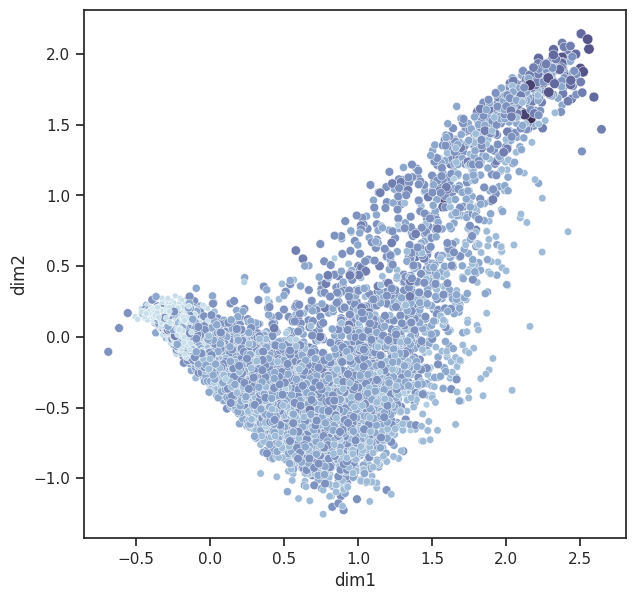

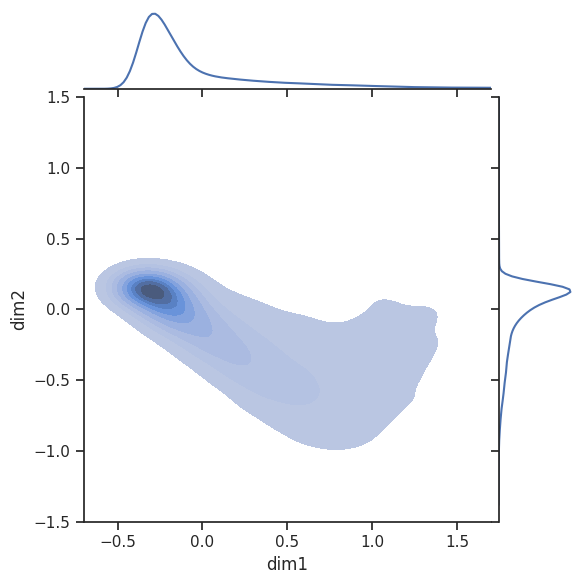

In [ ]:
emb_visualize(word2vec_item_emb_df, item_info, 'pca')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


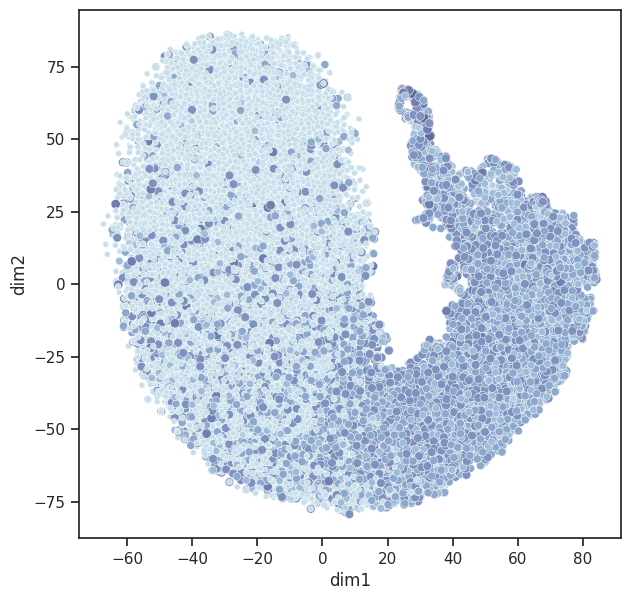

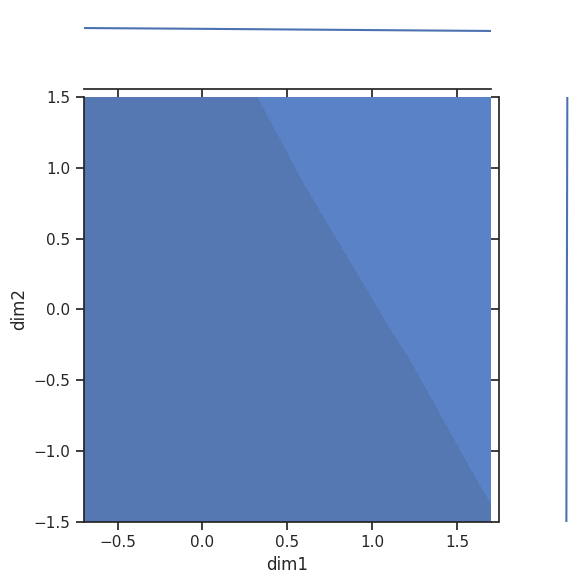

In [ ]:
emb_visualize(word2vec_item_emb_df, item_info, 'tsne')

In [ ]:
del w2vmodel
gc.collect()

18071

### 3.4.2 计算emb相似度和向量召回

In [ ]:
word2vec_emb_sim_dict = get_emb_sim_dict(word2vec_item_emb_df, 300, 'IVF10,PQ16', use_gpu=False)

100%|██████████| 30636/30636 [00:32<00:00, 953.41it/s]


In [ ]:
if not DEBUG:
  if os.path.exists(os.path.join(save_dir, 'word2vec_emb_sim_dict.json')):
    os.remove(os.path.join(save_dir, 'word2vec_emb_sim_dict.json'))
  with open(os.path.join(save_dir, 'word2vec_emb_sim_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(word2vec_emb_sim_dict, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行

In [ ]:
sim_item_topk = 300
recall_item_num = 180
alpha = 7
beta = 0.4

all_users = hist_click_df['user_id'].unique()
    
word2vec_recall_items_dict = multitask_i2i_recall(all_users, user_item_ctx_dict, \
                          word2vec_emb_sim_dict, sim_item_topk, recall_item_num, \
                          topk_hot_item, filter_dict, max_threads, alpha, beta)

    
# user_multi_recall_dict['word2vec_item_recall'] = word2vec_recall_items_dict

if metric_recall:
    metrics_recall(word2vec_recall_items_dict, last_click_df, topk=recall_item_num)

100%|██████████| 62500/62500 [07:21<00:00, 141.61it/s]


merging multi-worker results...


100%|██████████| 4/4 [01:30<00:00, 22.57s/it]


 topk:  10  :  hit_rate:  0.15862 mrr: 0.05601 user_num :  250000
 topk:  20  :  hit_rate:  0.22337 mrr: 0.0605 user_num :  250000
 topk:  30  :  hit_rate:  0.26236 mrr: 0.06207 user_num :  250000
 topk:  40  :  hit_rate:  0.28804 mrr: 0.06282 user_num :  250000
 topk:  50  :  hit_rate:  0.30276 mrr: 0.06314 user_num :  250000
 topk:  60  :  hit_rate:  0.31369 mrr: 0.06334 user_num :  250000
 topk:  70  :  hit_rate:  0.32228 mrr: 0.06347 user_num :  250000
 topk:  80  :  hit_rate:  0.32987 mrr: 0.06357 user_num :  250000
 topk:  90  :  hit_rate:  0.33641 mrr: 0.06365 user_num :  250000
 topk:  100  :  hit_rate:  0.34236 mrr: 0.06371 user_num :  250000
 topk:  110  :  hit_rate:  0.34734 mrr: 0.06376 user_num :  250000
 topk:  120  :  hit_rate:  0.3519 mrr: 0.0638 user_num :  250000
 topk:  130  :  hit_rate:  0.35605 mrr: 0.06383 user_num :  250000
 topk:  140  :  hit_rate:  0.36009 mrr: 0.06386 user_num :  250000
 topk:  150  :  hit_rate:  0.36363 mrr: 0.06389 user_num :  250000
 topk: 

In [ ]:
if not DEBUG:
  if os.path.exists(os.path.join(save_dir, 'word2vec_recall_items_dict.json')):
    os.remove(os.path.join(save_dir, 'word2vec_recall_items_dict.json'))

In [ ]:
if not DEBUG:
  with open(os.path.join(save_dir, 'word2vec_recall_items_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(word2vec_recall_items_dict, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行

In [ ]:
del word2vec_recall_items_dict
gc.collect()

33

# 4.多路召回合并

In [ ]:
def merge_recall_results(recall_result_path_dict, weight_dict=None, topk=25):
  final_recall_items_dict = {}
  
  def int_keys(ordered_pairs):
    result = {}
    for key, value in ordered_pairs:
      try:
        key = int(key)
      except ValueError:
        pass
      result[key] = value
    return result

  # 用户内对recall score做归一化
  def norm_user_recall_items_sim(sorted_item_list):
    if len(sorted_item_list) < 2:
      return sorted_item_list
    
    min_sim = sorted_item_list[-1][1]
    max_sim = sorted_item_list[0][1]
    
    norm_sorted_item_list = []
    for item, score in sorted_item_list:
      if max_sim > 0:
        norm_score = 1.0 * (score - min_sim) / (max_sim - min_sim) if max_sim > min_sim else 1.0
      else:
        norm_score = 0.0
      norm_sorted_item_list.append((item, norm_score))
      
    return norm_sorted_item_list
  
  print('Recall Results Merging...')
  methods = recall_result_path_dict.keys()
  for method in tqdm.tqdm(methods):
    with open(recall_result_path_dict[method], 'r', encoding="utf-8") as f:
      user_recall_items = json.load(f, object_pairs_hook=int_keys)
    # 每路召回的权重设定
    recall_method_weight = weight_dict[method]
    
    # 分用户做recall score的归一化
    for user_id, sorted_item_list in user_recall_items.items():
      user_recall_items[user_id] = norm_user_recall_items_sim(sorted_item_list)
    
    # 多路召回合并，recall_score * recall_weight 再做相加
    for user_id, sorted_item_list in user_recall_items.items():
      final_recall_items_dict.setdefault(user_id, {})
      for item, score in sorted_item_list:
        final_recall_items_dict[user_id].setdefault(item, 0)
        final_recall_items_dict[user_id][item] += recall_method_weight * score  
    
    del user_recall_items
    gc.collect()

  final_recall_items_dict_rank = {}
  # 控制最终的召回数量
  for user, recall_item_dict in final_recall_items_dict.items():
    final_recall_items_dict_rank[user] = sorted(recall_item_dict.items(), key=lambda x: x[1], reverse=True)[:topk]

  return final_recall_items_dict_rank

In [ ]:
recall_result_path_dict = {}
recall_result_path_dict['itemcf_recall'] = os.path.join(data_dir, 'itemcf_recall_items_dict.json')
recall_result_path_dict['binetwork_recall'] = os.path.join(data_dir, 'binetwork_recall_items_dict.json')
recall_result_path_dict['word2vec_item_recall'] = os.path.join(data_dir, 'word2vec_recall_items_dict.json')

In [ ]:
weight_dict = {'itemcf_recall': 0.4,
        'binetwork_recall': 0.5,
        'word2vec_item_recall': 0.1
        }

In [ ]:
# 最终合并之后每个用户召回150个商品进行排序
final_topk = 150
final_recall_items_dict = merge_recall_results(recall_result_path_dict, weight_dict, topk=final_topk)
if metric_recall:
  metrics_recall(final_recall_items_dict, last_click_df, topk=final_topk)

Recall Results Merging...


100%|██████████| 3/3 [06:45<00:00, 135.19s/it]


 topk:  10  :  hit_rate:  0.45894 mrr: 0.23365 user_num :  250000
 topk:  20  :  hit_rate:  0.56111 mrr: 0.24081 user_num :  250000
 topk:  30  :  hit_rate:  0.6136 mrr: 0.24293 user_num :  250000
 topk:  40  :  hit_rate:  0.6481 mrr: 0.24392 user_num :  250000
 topk:  50  :  hit_rate:  0.67259 mrr: 0.24446 user_num :  250000
 topk:  60  :  hit_rate:  0.69093 mrr: 0.24479 user_num :  250000
 topk:  70  :  hit_rate:  0.70579 mrr: 0.24502 user_num :  250000
 topk:  80  :  hit_rate:  0.71726 mrr: 0.24517 user_num :  250000
 topk:  90  :  hit_rate:  0.72709 mrr: 0.24529 user_num :  250000
 topk:  100  :  hit_rate:  0.73544 mrr: 0.24538 user_num :  250000
 topk:  110  :  hit_rate:  0.74273 mrr: 0.24545 user_num :  250000
 topk:  120  :  hit_rate:  0.74948 mrr: 0.2455 user_num :  250000
 topk:  130  :  hit_rate:  0.75552 mrr: 0.24555 user_num :  250000
 topk:  140  :  hit_rate:  0.76118 mrr: 0.24559 user_num :  250000
 topk:  150  :  hit_rate:  0.76634 mrr: 0.24563 user_num :  250000


In [ ]:
if not DEBUG:
  if os.path.exists(os.path.join(save_dir, 'recall_items_dict.json')):
    os.remove(os.path.join(save_dir, 'recall_items_dict.json'))

In [ ]:
if not DEBUG:
  with open(os.path.join(save_dir, 'recall_items_dict.json'), 'w', encoding='utf-8') as f:
    json.dump(final_recall_items_dict, f, indent=2, sort_keys=True, ensure_ascii=False) # 写为多行